   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

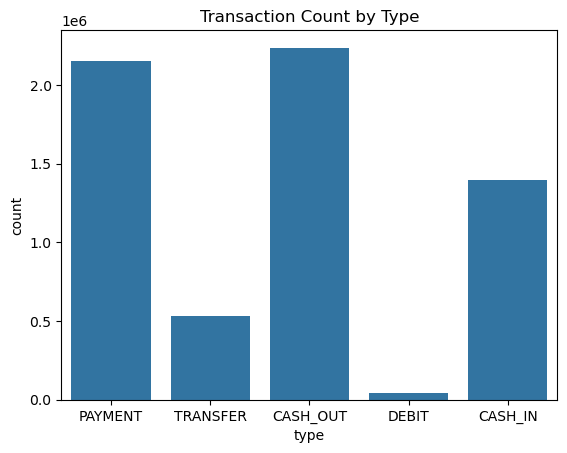

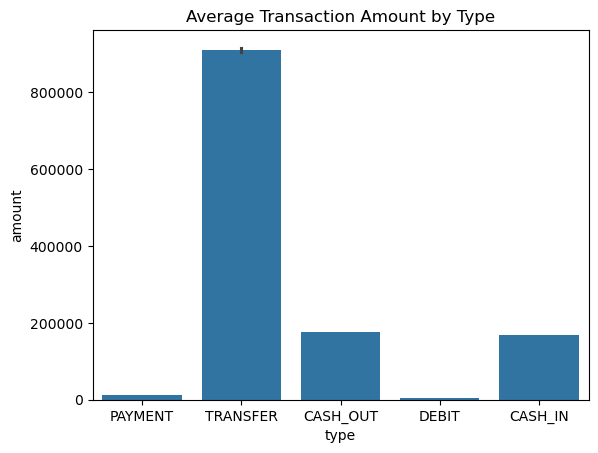

isFraud
0    6354407
1       8213
Name: count, dtype: int64


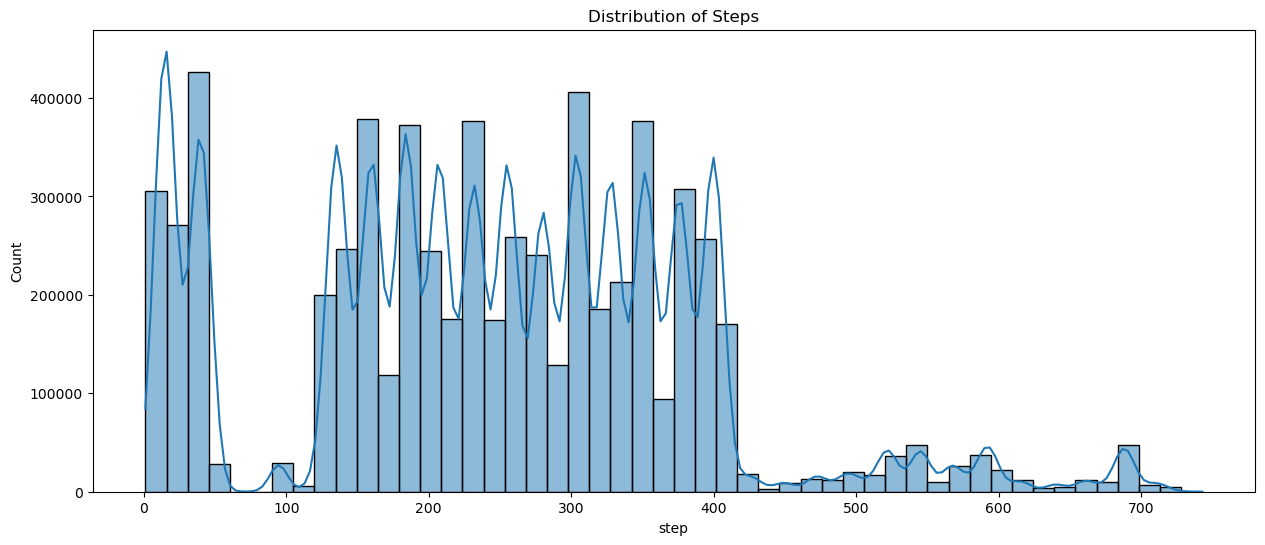

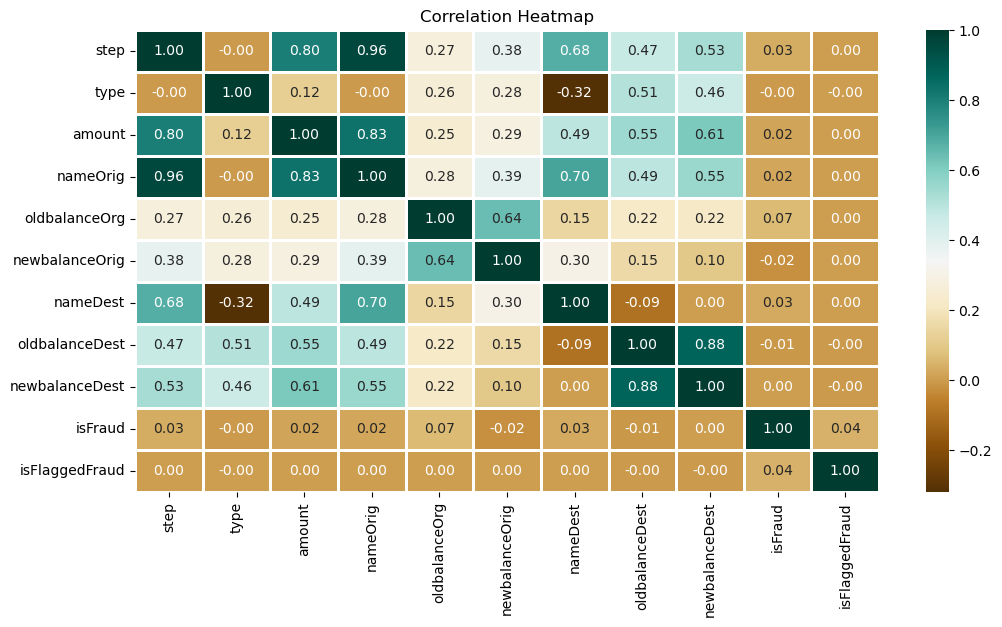

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0     False  False     True     False  
1     False  False

ModuleNotFoundError: No module named 'xgboost'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("/users/tayli/OneDrive/Documents/payments_data.csv")

# Quick data overview
print(data.head())
print(data.info())
print(data.describe())

# Check variable types
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))

# Visualization 1 - Countplot
sns.countplot(x='type', data=data)
plt.title("Transaction Count by Type")
plt.show()

# Visualization 2 - Barplot
sns.barplot(x='type', y='amount', data=data)
plt.title("Average Transaction Amount by Type")
plt.show()

# Value counts for fraud
print(data['isFraud'].value_counts())

# Visualization 3 - Distribution of steps
plt.figure(figsize=(15, 6))
sns.histplot(data['step'], bins=50, kde=True)
plt.title("Distribution of Steps")
plt.show()

# Visualization 4 - Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data.apply(lambda x: pd.factorize(x)[0]).corr(),
            cmap='BrBG',
            fmt='.2f',
            linewidths=2,
            annot=True)
plt.title("Correlation Heatmap")
plt.show()

# Feature Engineering: One-hot encode transaction type
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)

print(data_new.head())

# Define features and target
X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']

print(X.shape, y.shape)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Models
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as ras
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = [
    LogisticRegression(max_iter=1000),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
]

# Train and evaluate models
for model in models:
    model.fit(X_train, y_train)
    print(f'{model} : ')
    
    train_preds = model.predict_proba(X_train)[:, 1]
    print('Training AUC : ', ras(y_train, train_preds))
    
    y_preds = model.predict_proba(X_test)[:, 1]
    print('Validation AUC : ', ras(y_test, y_preds))
    print()

# Confusion Matrix for XGBoost
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(models[1], X_test, y_test)
cm.plot(cmap='viridis')
plt.title("Confusion Matrix - XGBoost")
plt.show()
